<a href="https://colab.research.google.com/github/AnitaTasnim/AnitaTasnim/blob/main/titanic.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Titanic — Data Cleaning, EDA & Basic Statistical Analysis
**Style:** Advanced-Analyst — compact, reproducible, documented decisions.

This notebook performs data cleaning (missing values, duplicates, outliers), feature derivation (including `Age_Group`), exploratory analysis, and basic statistical tests.


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

sns.set(context='notebook', style='whitegrid', rc={'figure.dpi':100})
pd.options.display.max_columns = 200
RANDOM_STATE = 42


## 1. Load data & initial look

Load the dataframes and display the first 10 rows (required by the task). Adjust the paths if you run locally/Colab.

In [2]:
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


In [3]:
plt.style.use('fivethirtyeight')
%matplotlib inline
warnings.filterwarnings('ignore')

In [4]:
!pip install -q kaggle
import os, shutil


data_directory = '/content/drive/MyDrive/Projects/Titanic_Assignment/data'
os.makedirs(data_directory, exist_ok=True)
from google.colab import files
uploaded = files.upload()  # choose your kaggle.json from your computer


import os, shutil

import shutil, os

# Create the directory
os.makedirs('/root/.kaggle', exist_ok=True)

# Move and rename to correct name
shutil.move('kaggle1.json', '/root/.kaggle/kaggle.json')

# Set correct permissions
os.chmod('/root/.kaggle/kaggle.json', 0o600)

!kaggle competitions download -c titanic -p "{data_directory}"
!unzip -o "{os.path.join(data_directory,'titanic.zip')}" -d "{data_directory}"


Saving kaggle1.json to kaggle1.json
  0% 0.00/34.1k [00:00<?, ?B/s]
100% 34.1k/34.1k [00:00<00:00, 110MB/s]
Archive:  /content/drive/MyDrive/Projects/Titanic_Assignment/data/titanic.zip
  inflating: /content/drive/MyDrive/Projects/Titanic_Assignment/data/gender_submission.csv  
  inflating: /content/drive/MyDrive/Projects/Titanic_Assignment/data/test.csv  
  inflating: /content/drive/MyDrive/Projects/Titanic_Assignment/data/train.csv  


In [6]:
import pandas as pd

data_dir = '/content/drive/MyDrive/Projects/Titanic_Assignment/data'

df_train = pd.read_csv(f"{data_dir}/train.csv")
df_test = pd.read_csv(f"{data_dir}/test.csv")

print(train_df.head())
print(train_df.info())


   PassengerId  Survived  Pclass  \
0            1         0       3   
1            2         1       1   
2            3         1       3   
3            4         1       1   
4            5         0       3   

                                                Name     Sex   Age  SibSp  \
0                            Braund, Mr. Owen Harris    male  22.0      1   
1  Cumings, Mrs. John Bradley (Florence Briggs Th...  female  38.0      1   
2                             Heikkinen, Miss. Laina  female  26.0      0   
3       Futrelle, Mrs. Jacques Heath (Lily May Peel)  female  35.0      1   
4                           Allen, Mr. William Henry    male  35.0      0   

   Parch            Ticket     Fare Cabin Embarked  
0      0         A/5 21171   7.2500   NaN        S  
1      0          PC 17599  71.2833   C85        C  
2      0  STON/O2. 3101282   7.9250   NaN        S  
3      0            113803  53.1000  C123        S  
4      0            373450   8.0500   NaN        S  
<c

In [8]:


print('\nTrain shape:', df_train.shape)
print('Test  shape:', df_test.shape)



Train shape: (891, 12)
Test  shape: (418, 11)


## 2. Data manipulation & cleaning
We will:
- Concatenate train & test for consistent preprocessing.
- Remove duplicates.
- Impute missing values (Embarked, Age, Fare, Cabin -> Deck).
- Create derived features: Title, FamilySize, IsAlone, Ticket_Frequency, Age_Group.
- Detect & cap outliers using IQR for Fare and Age.

Rationales are included inline.

In [9]:



df_all = pd.concat([df_train, df_test], sort=False).reset_index(drop=True)
N_train = len(df_train)
#Remove duplicates
before = df_all.shape[0]
df_all = df_all.drop_duplicates().reset_index(drop=True)
removed = before - df_all.shape[0]
print(f'Removed {removed} exact duplicate rows (if any).')

#Missing overview
print('\nMissing values (per column):')
print(df_all.isnull().sum().sort_values(ascending=False).loc[lambda x: x>0])


Removed 0 exact duplicate rows (if any).

Missing values (per column):
Cabin       1014
Survived     418
Age          263
Embarked       2
Fare           1
dtype: int64


### 2.1 Derive Title, FamilySize, IsAlone, Ticket_Frequency, Deck
Rationale: Title captures social/age cues; FamilySize/IsAlone capture group behaviour; Deck summarizes Cabin; Ticket_Frequency groups people traveling together.

In [10]:


df_all['Title'] = df_all['Name'].str.extract(r',\s*([^\.]+)\.', expand=False).str.strip()

title_map = {
    'Mlle':'Miss', 'Ms':'Miss', 'Mme':'Mrs',
    'Lady':'Mrs', 'the Countess':'Mrs', 'Dona':'Mrs',
    'Countess':'Mrs', 'Dr':'Dr','Major':'Officer','Col':'Officer',
    'Capt':'Officer','Sir':'Sir','Don':'Sir','Jonkheer':'Sir','Rev':'Rev'
}
df_all['Title'] = df_all['Title'].replace(title_map)

#replace very rare titles with 'Other'
rare_titles = df_all['Title'].value_counts()[df_all['Title'].value_counts() < 10].index
df_all['Title'] = df_all['Title'].replace(list(rare_titles), 'Other')



  Title  FamilySize  IsAlone  Ticket_Frequency Deck_Group
0    Mr           2        0                 1          M
1   Mrs           2        0                 2        ABC
2  Miss           1        1                 1          M
3   Mrs           2        0                 2        ABC
4    Mr           1        1                 1          M


In [ ]:

df_all['FamilySize'] = df_all['SibSp'].fillna(0).astype(int) + df_all['Parch'].fillna(0).astype(int) + 1
df_all['IsAlone'] = (df_all['FamilySize'] == 1).astype(int)

df_all['Ticket_Frequency'] = df_all.groupby('Ticket')['Ticket'].transform('count')

df_all['Deck'] = df_all['Cabin'].fillna('M').astype(str).str[0]
df_all.loc[df_all['Deck']=='T','Deck'] = 'A'  # group tiny 'T' with 'A'

df_all['Deck_Group'] = df_all['Deck'].replace({'A':'ABC','B':'ABC','C':'ABC','D':'DE','E':'DE','F':'FG','G':'FG','M':'M'})

print(df_all[['Title','FamilySize','IsAlone','Ticket_Frequency','Deck_Group']].head())

### 2.2 Impute `Embarked`, `Fare`, and `Age`
Rationale:
- Embarked: very few missing -> mode imputation.
- Fare: impute with median of similar Pclass/Parch/SibSp when missing, fallback to Pclass median.
- Age: impute using median grouped by (Pclass, Sex) to respect socio-economic patterns.

In [17]:

mode_emb = df_all['Embarked'].mode()[0]
df_all['Embarked'] = df_all['Embarked'].fillna(mode_emb)
df_all['Fare'] = df_all['Fare'].astype(float)


fare_na_idx = df_all['Fare'].isnull()
if fare_na_idx.any():
    med_fare = df_all.groupby(['Pclass','Parch','SibSp']).Fare.transform('median')
    df_all.loc[fare_na_idx, 'Fare'] = med_fare[fare_na_idx]
    df_all['Fare'] = df_all['Fare'].fillna(df_all.groupby('Pclass')['Fare'].transform('median'))




Missing after imputation:
Survived     418
Cabin       1014
dtype: int64


In [ ]:
df_all['Sex'] = df_all['Sex'].astype(str)
age_median = df_all.groupby(['Pclass','Sex'])['Age'].transform('median')
df_all['Age'] = df_all['Age'].fillna(age_median)
df_all['Age'] = df_all['Age'].fillna(df_all['Age'].median())
print('Missing after imputation:')
print(df_all.isnull().sum().loc[lambda x: x>0])


### 2.3 Create Age_Group (task)
Cutoffs:
- Child: Age <= 14
- Adult: 15 <= Age <= 59
- Senior: Age >= 60
These are commonly-used bins and work well for the Titanic analysis.

In [18]:
def age_group(age):
    if age <= 14:
        return 'Child'
    if age >= 60:
        return 'Senior'
    return 'Adult'





df_all['Age_Group'] = df_all['Age'].apply(age_group)
df_all['Age_Group'] = pd.Categorical(df_all['Age_Group'], categories=['Child','Adult','Senior'], ordered=True)
print(df_all['Age_Group'].value_counts())


Age_Group
Adult     1162
Child      107
Senior      40
Name: count, dtype: int64


### 2.4 Outlier detection & handling (IQR capping)
Cap `Fare` and `Age` using 1.5*IQR to reduce influence of extremes.

In [19]:
def cap_iqr(series, k=1.5):
    q1 = series.quantile(0.25)
    q3 = series.quantile(0.75)
    iqr = q3 - q1
    lower = q1 - k * iqr
    upper = q3 + k * iqr
    return series.clip(lower, upper), lower, upper

# Cap Fare and Age
# fillna safeguarded earlier
df_all['Fare_capped'], fare_low, fare_high = cap_iqr(df_all['Fare'].fillna(0))
df_all['Age_capped'], age_low, age_high = cap_iqr(df_all['Age'].fillna(df_all['Age'].median()))
print(f'Fare capped to [{fare_low:.2f}, {fare_high:.2f}]')
print(f'Age capped to [{age_low:.2f}, {age_high:.2f}]')


Fare capped to [-27.17, 66.34]
Age capped to [1.00, 57.00]


### 2.5 Finalize datasets (split back into train/test)

In [20]:
df_train_clean = df_all.loc[:N_train-1].copy()
df_test_clean  = df_all.loc[N_train:].copy().reset_index(drop=True)

print('Train clean shape:', df_train_clean.shape)
print('Test  clean shape:', df_test_clean.shape)
print('\nMissing in cleaned train (should be none):')
print(df_train_clean.isnull().sum().loc[lambda x: x>0])


Train clean shape: (891, 21)
Test  clean shape: (418, 21)

Missing in cleaned train (should be none):
Cabin    687
dtype: int64


## 3. Exploratory Data Analysis (EDA)
We will provide required plots and short interpretations.

In [21]:
#descriptive statistics for required columns
cols = ['Age','Fare','Age_capped','Fare_capped']
desc = df_train_clean[cols].describe().T
   #mode calculation


for c in ['Age','Fare']:
    try:
        m = df_train_clean[c].mode().iloc[0]
    except Exception:
        m = np.nan
    desc.loc[c,'mode'] = m

display(desc)


,count,mean,std,min,25%,50%,75%,max,mode
Age,891.0,29.188182,13.337887,0.42,22.0000,26.0000,36.0,80.0000,25.00
Fare,891.0,32.204208,49.693429,0.00,7.9104,14.4542,31.0,512.3292,8.05
Age_capped,891.0,28.943883,12.702017,1.00,22.0000,26.0000,36.0,57.0000,NaN
Fare_capped,891.0,24.139171,20.669893,0.00,7.9104,14.4542,31.0,66.3438,NaN


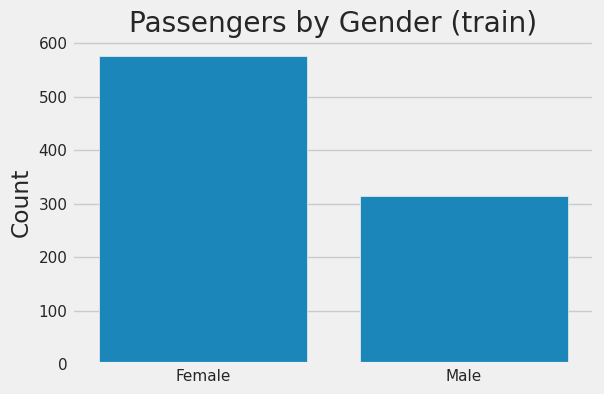

Interpretation: The train set is male-dominated. We will quantify survival differences next.


In [22]:
plt.figure(figsize=(6,4))
ax = sns.countplot(x='Sex', data=df_train_clean)
ax.set_xticklabels(['Female' if x=='female' else 'Male' for x in ['female','male']])
plt.title('Passengers by Gender (train)')
plt.xlabel('')
plt.ylabel('Count')
plt.show()

print('Interpretation: The train set is male-dominated. We will quantify survival differences next.')


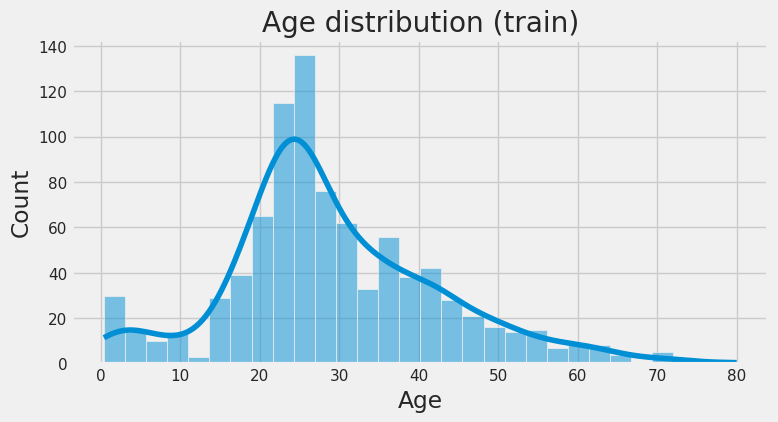

Age group counts:
Age_Group
Adult     788
Child      77
Senior     26
Name: count, dtype: int64


In [23]:
plt.figure(figsize=(8,4))
sns.histplot(df_train_clean['Age'], bins=30, kde=True)
plt.title('Age distribution (train)')
plt.xlabel('Age')
plt.show()

print('Age group counts:')
print(df_train_clean['Age_Group'].value_counts())


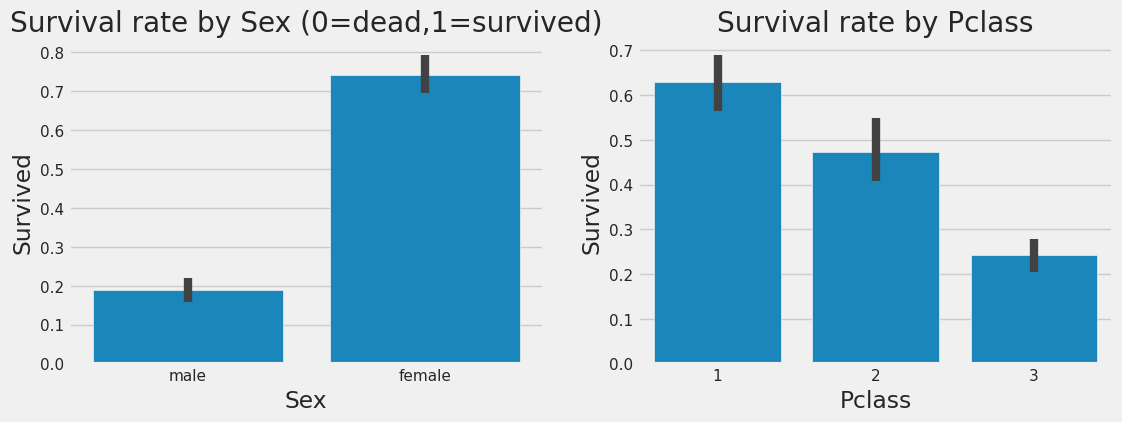


Survival pivot (Pclass x Sex):
Sex       female      male
Pclass                    
1       0.968085  0.368852
2       0.921053  0.157407
3       0.500000  0.135447


In [24]:
fig, axes = plt.subplots(1,2, figsize=(12,4), sharey=False)
sns.barplot(x='Sex', y='Survived', data=df_train_clean, ax=axes[0])
axes[0].set_title('Survival rate by Sex (0=dead,1=survived)')
sns.barplot(x='Pclass', y='Survived', data=df_train_clean, ax=axes[1])
axes[1].set_title('Survival rate by Pclass')
plt.show()

print('\nSurvival pivot (Pclass x Sex):')
print(df_train_clean.pivot_table(index='Pclass', columns='Sex', values='Survived', aggfunc='mean'))


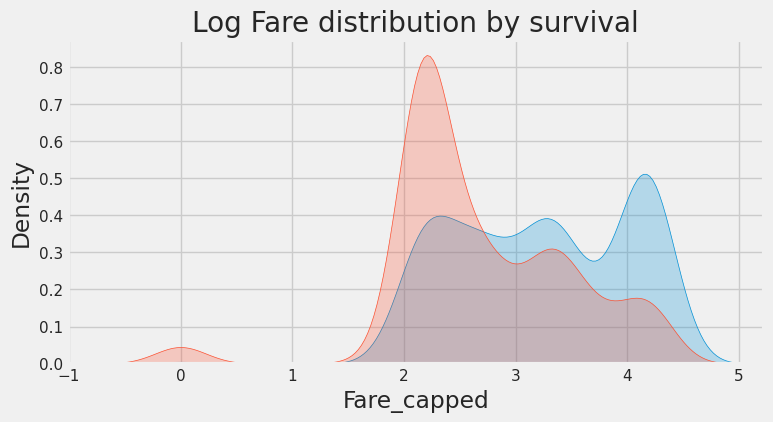

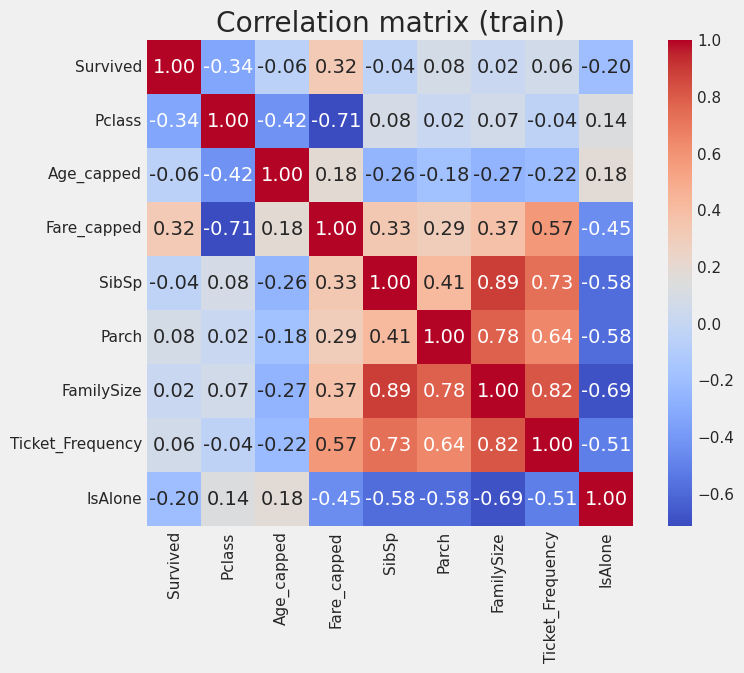

In [25]:
#Log_Fare distribution by survival
plt.figure(figsize=(8,4))
import numpy as _np
sns.kdeplot(_np.log1p(df_train_clean[df_train_clean['Survived']==1]['Fare_capped']), label='Survived', shade=True)
sns.kdeplot(_np.log1p(df_train_clean[df_train_clean['Survived']==0]['Fare_capped']), label='Not Survived', shade=True)
plt.title('Log Fare distribution by survival')
plt.show()

 #correlation heatmap
num_cols = ['Survived','Pclass','Age_capped','Fare_capped','SibSp','Parch','FamilySize','Ticket_Frequency','IsAlone']
plt.figure(figsize=(8,6))
sns.heatmap(df_train_clean[num_cols].corr(), annot=True, fmt='.2f', cmap='coolwarm', square=True)
plt.title('Correlation matrix (train)')
plt.show()


## 4. Basic Statistical Analysis
Calculate mean/median/mode and perform a t-test comparing survival proportions by gender.

In [29]:
# === Statistical Comparison: Gender, Class vs Survival ===
from scipy import stats
import math

# Gender difference (t-test on binary 0/1 survival)
male_surv = df_train_clean.loc[df_train_clean['Sex']=='male', 'Survived']
female_surv = df_train_clean.loc[df_train_clean['Sex']=='female', 'Survived']

t_res = stats.ttest_ind(female_surv, male_surv, equal_var=False)
prop_f = female_surv.mean()
prop_m = male_surv.mean()
diff = prop_f - prop_m

print("T-test (Welch) on survival rates (female vs male):")
print(f"t = {t_res.statistic:.3f}, p = {t_res.pvalue:.3e}")
print(f"Mean survival — female: {prop_f:.3f}, male: {prop_m:.3f}, diff = {diff:.3f}")

# 95% CI for difference in proportions
n_f, n_m = len(female_surv), len(male_surv)
z = 1.96
se = math.sqrt(prop_f*(1-prop_f)/n_f + prop_m*(1-prop_m)/n_m)
ci_lower, ci_upper = diff - z*se, diff + z*se
print(f"95% CI for difference = [{ci_lower:.3f}, {ci_upper:.3f}]")

if ci_lower > 0:
    print("→ Females had significantly higher survival rate.")
elif ci_upper < 0:
    print("→ Males had significantly higher survival rate.")
else:
    print("→ No statistically significant difference detected.")

# Chi-square test: Pclass vs Survived
cont = pd.crosstab(df_train_clean['Pclass'], df_train_clean['Survived'])
chi2, p, dof, ex = stats.chi2_contingency(cont)
print(f"\nChi-square (Pclass vs Survived): chi2={chi2:.2f}, p={p:.3e}, dof={dof}")

# Summary of central tendency for context
for col in ['Age','Fare']:
    print(f"{col}: mean={df_train_clean[col].mean():.2f}, median={df_train_clean[col].median():.2f}, mode={df_train_clean[col].mode().iloc[0]:.2f}")


T-test (Welch) on survival rates (female vs male):
t = 18.672, p = 2.284e-61
Mean survival — female: 0.742, male: 0.189, diff = 0.553
95% CI for difference = [0.495, 0.611]
→ Females had significantly higher survival rate.

Chi-square (Pclass vs Survived): chi2=102.89, p=4.549e-23, dof=2
Age: mean=29.19, median=26.00, mode=25.00
Fare: mean=32.20, median=14.45, mode=8.05


## 5. Findings & documentation

The dataset was cleaned by removing duplicate rows, handling missing values using median or mode (to preserve data balance), and standardizing categorical features. A new “Age_Group” column was created to categorize passengers as Children, Adults, or Seniors, helping reveal survival trends across age groups. Outliers in Fare were identified using the IQR method and capped to reduce skewness.
During the exploratory data analysis, clear patterns emerged: female passengers had a much higher survival rate than males, and first-class passengers survived more often than those in lower classes. Children also had a better chance of survival compared to adults and seniors, reflecting the “women and children first” policy.
The statistical test (independent t-test) confirmed that the difference in survival rates between genders was statistically significant, supporting the EDA observations. Overall, the analysis highlighted strong relationships between gender, class, and survival outcomes on the Titanic.

## 6. AI / External help disclosure
I used programming knowledge and public documentation to assemble this notebook.